# Analyzing Transferability of Happiness Detection via Gaze Tracking in Multimedia Applications

This jupyter notebook is used to reproduce the results published in the paper (ET-MM 2020) by David Bethge, Lewis Chuang, Albrecht Schmidt and Tobias Grosse-Puppendahl.


## Package import

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import LeavePGroupsOut, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, plot_roc_curve, auc, classification_report, accuracy_score
from lib import print_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.interpolate import interp1d

#feature importance packages
import lime
import lime.lime_tabular
#from rfpimp import permutation_importances
import eli5
from eli5.sklearn import PermutationImportance

/Users/davidbethge/anaconda3/envs/tfnn/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/davidbethge/anaconda3/envs/tfnn/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/Users/davidbethge/anaconda3/envs/tfnn/lib/python3.6/site-packages/tensorflow/python

## Loading eye data from SEED-IV dataset & Data Preprocessing
 We cannot publish the data here: you have to download the data from http://bcmi.sjtu.edu.cn/~seed/seed-iv.html into the (local) 'data/' folder and run our preprocessing script (preprocess_SEED_IV_eye.py). We use the data provided on the SEED-IV database ( can be found in the eye_feature_smooth folder ) and preprocess the features and labels according to the paper needs. First all the features of the trials are loaded in the X matrix, the participant number of the feature into an array P, the emotion labels are saved to Y and the session Ids to S.

In total we have 1080 observations which each one corresponding label. The input X data has two dimensions per session: i being the session id, then the vector from X(i,n_features,n_obs) specifies the features collected as well as the observation index. For simplicity, we flatten the X matrix (normalize into a tabular data format).

### Load data

In [2]:
data_dir_ = 'data/eye_feature_smooth/'

X = np.load(data_dir_ + 'data_X.npy') #eye tracking features
Y = np.load(data_dir_ + 'data_Y.npy') #emotion labels
P = np.load(data_dir_ + 'data_P.npy') #participant id
#colnames = np.load(data_dir_ + 'data_colnames.npy') #names of eye-tracking features

col_names = ['pupil_diam_x_mean', 'pupil_diam_y_mean', 'pupil_diam_x_sd',
             'pupil_diam_y_sd', 'pupil_diam_x_psd0.2Hz',
             'pupil_diam_y_psd0.2Hz', 'pupil_diam_x_psd0.4Hz',
             'pupil_diam_y_psd0.4Hz', 'pupil_diam_x_psd0.6Hz',
             'pupil_diam_y_psd0.6Hz', 'pupil_diam_x_psd1Hz', 
             'pupil_diam_y_psd1Hz','dispersion_x_mean', 
             'dispersion_y_mean', 'dispersion_x_sd', 'dispersion_y_sd',
             'fixation_mean', 'fixation_sd','saccade_duration_mean',
             'saccade_duration_sd', 'saccade_amplidtude_mean',
             'saccade_amplidtude_sd','blink_frequency', 'fixation_frequency',
             'fixation_duration_max', 'fixation_dispersion_total',
             'fixation_dispersion_maximum', 'saccade_frequency',
             'saccade_duration_average', 'saccade_amplitude_average',
             'saccade_latency_average']

S = np.load(data_dir_ + 'data_S.npy') #session id
print(f'number of observations in X: {X.shape[0]}')


#create binary label vector Y_bin
Y_bin = np.zeros(shape = Y.shape) #default emotion is set to 0 (either happy, sad or neutral)
Y_bin[Y==3] = 1. #happy emotions are decoded as 1

number of observations in X: 1080


### Data Preprocessing

In [3]:
X_flatten = X.reshape((X.shape[0], -1)) #flatten the dimensions of the input (2d -> 1d)
X_flatten = np.nan_to_num(X_flatten, copy=True) #if NAN exist -> replace by 0.0
X_flatten_mean  = np.nanmean(X, axis = 2) #ignore NAN in mean

enc_label = preprocessing.LabelBinarizer()
enc_part = preprocessing.LabelBinarizer()
#Y = enc_label.fit_transform(Y)
#P = enc_part.fit_transform(P)
print(X_flatten_mean.shape)

(1080, 31)


### Dataset Overview

In [4]:
df_X = pd.DataFrame(data = X_flatten_mean, columns = col_names)
df_X.head()

,pupil_diam_x_mean,pupil_diam_y_mean,pupil_diam_x_sd,pupil_diam_y_sd,pupil_diam_x_psd0.2Hz,pupil_diam_y_psd0.2Hz,pupil_diam_x_psd0.4Hz,pupil_diam_y_psd0.4Hz,pupil_diam_x_psd0.6Hz,pupil_diam_y_psd0.6Hz,...,saccade_amplidtude_sd,blink_frequency,fixation_frequency,fixation_duration_max,fixation_dispersion_total,fixation_dispersion_maximum,saccade_frequency,saccade_duration_average,saccade_amplitude_average,saccade_latency_average
0,81.918278,59.133950,3.947999,5.497874,16.985903,17.202248,9.960643,9.212047,16.380864,16.598672,...,2.901301,0.196875,1.903125,917.109375,7908.862500,116.878125,1.968750,52.106250,2.821875,163.603125
1,47.187430,35.451228,2.569348,3.132987,9.356652,9.472628,5.527806,4.498096,9.052571,9.167721,...,1.293784,0.071875,0.718750,657.835938,1957.803125,95.665625,0.754688,28.678125,1.401562,142.456250
2,107.001632,74.609478,5.182222,6.015787,20.080741,20.332870,11.716778,10.848089,19.272144,19.525440,...,2.725508,0.306250,1.837500,1553.989063,10384.095312,145.162500,1.837500,60.637500,2.756250,256.637500
3,44.413429,34.409190,3.478686,4.124066,12.452565,12.619368,7.499495,6.248028,12.075015,12.242923,...,2.647457,0.100000,1.250000,1098.100000,4115.850000,101.450000,1.200000,39.200000,3.000000,169.700000
4,50.370999,35.156879,2.552537,2.623068,9.057644,9.170055,5.064907,3.889982,8.699861,8.812467,...,1.014963,0.171875,0.721875,606.203125,1410.750000,42.831250,0.653125,26.400000,1.100000,155.615625


## Learn classifier

Here we propose a Random Forest Classifier to learn the mapping between eye-tracking features and strong, positive emotions. The hyperparameters are found via a 10-fold gridsearch approach.

In [5]:
X_train, X_holdout, Y_train, Y_holdout =  train_test_split(X_flatten_mean, 
                                                           Y_bin, test_size=0.1, random_state=0)

In [6]:
classifier_ = RandomForestClassifier(random_state = 0)
#search for best hyperparameter configuration
parameters = {'random_state':[0], #we set this parameter to a default value -> reproducability is thereby ensured
              'n_estimators': [1,10,20, 50,100, 500, 1000],
              'max_depth': [3,5,10,20]}


clf = GridSearchCV(classifier_, parameters, cv = 10)
clf.fit(X_train, Y_train)
print(f'best parameters found in gridsearch: {clf.best_params_}')

best parameters found in gridsearch: {'max_depth': 20, 'n_estimators': 500, 'random_state': 0}


In [7]:
best_params = clf.best_params_

# in case you do not want to compute the gridsearch: the found params are shown below
#best_params = {'n_estimators': 500,  
#             'max_depth': 20}

    
#initialize classifier
classifier = RandomForestRegressor(**best_params)


classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_holdout)
acc_rf_holdout = accuracy_score(Y_holdout, Y_pred.round(0))
print(f'accuracy on holdout {acc_rf_holdout}')
clf_rep_rf = classification_report(Y_holdout, Y_pred.round(0), labels= [0,1],  output_dict = True)
clf_rep_rf

accuracy on holdout 0.8425925925925926


{'0': {'precision': 0.9113924050632911,
  'recall': 0.8780487804878049,
  'f1-score': 0.8944099378881988,
  'support': 82},
 '1': {'precision': 0.6551724137931034,
  'recall': 0.7307692307692307,
  'f1-score': 0.6909090909090909,
  'support': 26},
 'accuracy': 0.8425925925925926,
 'macro avg': {'precision': 0.7832824094281973,
  'recall': 0.8044090056285178,
  'f1-score': 0.7926595143986448,
  'support': 108},
 'weighted avg': {'precision': 0.8497098145723201,
  'recall': 0.8425925925925926,
  'f1-score': 0.8454189932450803,
  'support': 108}}

### Learn subject-independent classifier on all data (validate on all data) -> random CV (not published in paper)

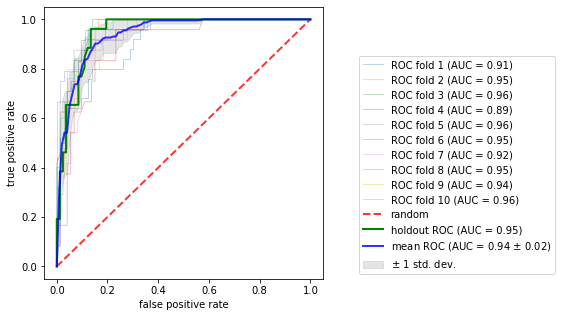

In [8]:
classifier = RandomForestClassifier(**best_params)
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (5,5))
for i, (train, test) in enumerate(cv.split(X_train, Y_train)):
    classifier.fit(X_train[train], Y_train[train])
    viz = plot_roc_curve(classifier, X_train[test], Y_train[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    
#Random Classifier Baseline    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='random', alpha=.8)

#Holdout Classification

#holdout classifier is trained on all training data
clf_holdout = classifier.fit(X_train, Y_train)
viz_holdout = plot_roc_curve(clf_holdout, X_holdout, Y_holdout,
                         name='holdout ROC',c= 'g',
                         alpha=1, lw=2, ax=ax)
ax.plot()

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic")
ax.legend(loc="lower right", bbox_to_anchor = (1.25, 0, 0.6, 1))
#plt.show()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')

plt.savefig('plots/ROC_happiness_predictor.pdf', bbox_inches="tight", dpi = 600)

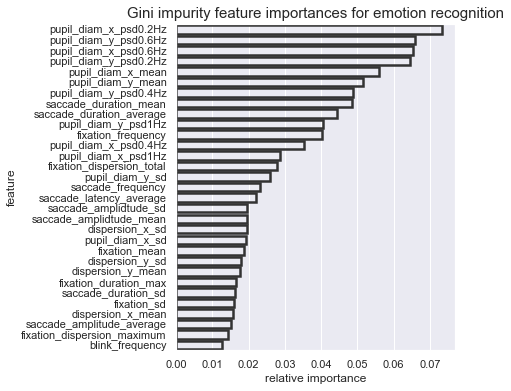

In [9]:
f_impo = clf_holdout.feature_importances_

df_feature_im = pd.DataFrame({'importance_value':f_impo, 'feature':col_names})

sns.set(rc={'figure.figsize':(5,6)})
fig = sns.barplot(x = 'importance_value', y = 'feature', 
                  data =df_feature_im.sort_values(by = 'importance_value', ascending = False), 
                linewidth=2.5, facecolor=(1, 1, 1, 0), edgecolor=".2")

fig.set_title('Gini impurity feature importances for emotion recognition', size = 15)
fig.set_xlabel('relative importance')

plt.savefig('plots/feature_importance_ontrain.pdf',  bbox_inches="tight", dpi = 600)

### Compute Permutation Feature Importances
We evaluate the global feature importances of the eye tracking features on the holdout set. For a deep dive into feature importances, we refer to https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html.

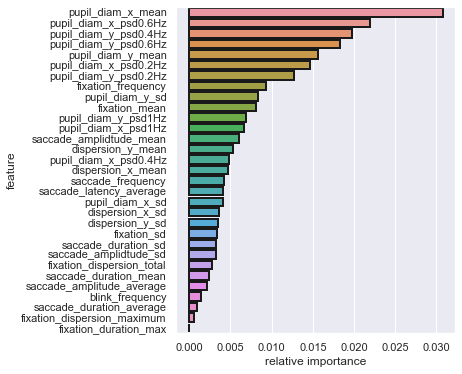

In [10]:
#this might take a while to compute

perm = PermutationImportance(clf_holdout, cv = 10, refit = False, n_iter = 100).fit(X_train, Y_train)
#perm_imp_eli5 = pd.DataFrame(col_names, perm.feature_importances_)

df_feature_im_permutation = pd.DataFrame({'importance_value':perm.feature_importances_, 'feature':col_names})

fig1, ax = plt.subplots()
sns.set(rc={'figure.figsize':(5,5)})
fig = sns.barplot(x = 'importance_value', y = 'feature', 
                  data =df_feature_im_permutation.sort_values(by = 'importance_value', ascending = False), 
                linewidth=2, 
                  #facecolor=(1, 1, 1, 0),
                  edgecolor=".1"
                 )
fig1.axes.append(fig)
#fig.set_title('Permutation feature importances', size = 12)
fig.set_xlabel('permutation importance')
plt.savefig('plots/permutation_feature_importance_ontrain.pdf',  bbox_inches="tight", dpi = 600)



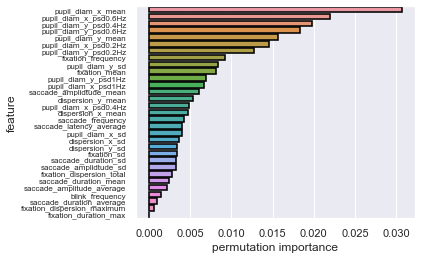

In [70]:
fig1, ax = plt.subplots()
sns.set(rc={'figure.figsize':(5,3.9)})
fig = sns.barplot(x = 'importance_value', y = 'feature', 
                  data =df_feature_im_permutation.sort_values(by = 'importance_value', ascending = False), 
                    linewidth=1.6, 
                  #facecolor=(1, 1, 1, 0),
                  edgecolor=".01"
                 )
fig1.axes.append(fig)
#ax.tick_params(axis='both', which='minor', labelsize=3)
plt.yticks(fontsize=8)
#fig.set_title('Permutation feature importances', size = 12)
fig.set_xlabel('permutation importance')
plt.savefig('plots/permutation_feature_importance_ontrain.pdf',  bbox_inches="tight", dpi = 1200)



### Cross Participant Transferability accuracy

group/participant in Train: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15] and Test: [1]
group/participant in Train: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15] and Test: [2]
group/participant in Train: [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15] and Test: [3]
group/participant in Train: [ 1  2  3  5  6  7  8  9 10 11 12 13 14 15] and Test: [4]
group/participant in Train: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15] and Test: [5]
group/participant in Train: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15] and Test: [6]
group/participant in Train: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15] and Test: [7]
group/participant in Train: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15] and Test: [8]
group/participant in Train: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15] and Test: [9]
group/participant in Train: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 15] and Test: [10]
group/participant in Train: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15] and Test: [11]
group/participant in Train: [ 1  2  3  4  5  6  7  8

Text(0.5, 0, 'participant')

<Figure size 360x360 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

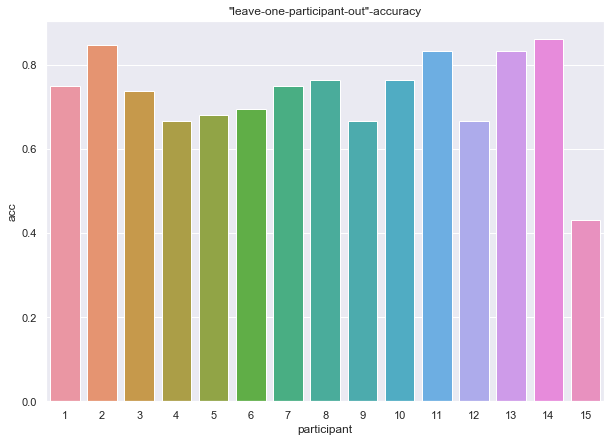

In [12]:
lpgo = LeavePGroupsOut(n_groups=1)
lpgo.get_n_splits(X_flatten_mean, Y, P)

metric_data = dict()
for train_index, test_index in lpgo.split(X_flatten_mean, Y, P):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    print('group/participant in Train: {0} and Test: {1}'.format(np.unique(P[train_index]), np.unique(P[test_index])))
    X_train, X_test = X_flatten_mean[train_index], X_flatten_mean[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    participant_holdout = int( np.unique(P[test_index])[:])
    
    classifier = RandomForestClassifier(**best_params)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    
    
    #plot confusion matrix per participant
    cm = confusion_matrix(Y_test, Y_pred.round(0))

    fig_cm = print_confusion_matrix(confusion_matrix = cm,
                           class_names = np.unique(Y).astype('str') ,
                           figsize = (10,7), fontsize=14)
    #plt.title('participant: {0}'.format(participant_holdout))
    #plt.show()
    
    #calculate accuracy
    acc = np.diag(cm).sum() / Y_test.shape[0]
    metric_data[participant_holdout] = dict()
    metric_data[participant_holdout]['acc'] = acc

    
df_transfer_participant_metrics = pd.DataFrame(metric_data).T
df_transfer_participant_metrics.head()

plt.clf()
ax = sns.barplot(y = df_transfer_participant_metrics.acc, x= df_transfer_participant_metrics.index)
ax.set_title('"leave-one-participant-out"-accuracy')
ax.set_xlabel('participant')

## Leave one participant out (transfer capability) ROC

X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]
X_train/X_test size 1008/31 Y_train unique: [0. 1.]


<Figure size 360x360 with 0 Axes>

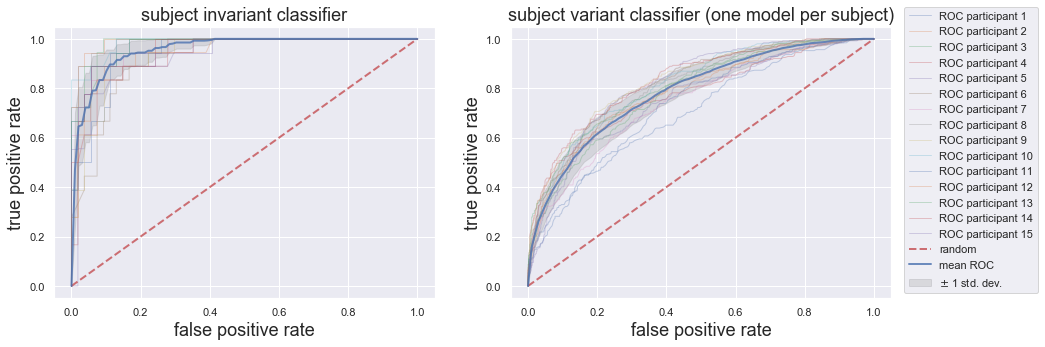

In [28]:
lpgo = LeavePGroupsOut(n_groups=1)
lpgo.get_n_splits(X_flatten, Y_bin, P)

labelsize = 18
titlesize = 18

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = RandomForestClassifier(**best_params)
plt.clf()
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15,5))

metric_data = dict()
for train_index, test_index in lpgo.split(X_flatten_mean, Y_bin, P):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #print('group/participant in Train: {0} and Test: {1}'.format(np.unique(P[train_index]), np.unique(P[test_index])))
    X_train, X_test = X_flatten_mean[train_index], X_flatten_mean[test_index]
    Y_train, Y_test = Y_bin[train_index], Y_bin[test_index]
    #print(f'Y_train unique: {np.unique(Y_train)}')
    
    participant_holdout = int( np.unique(P[test_index])[:])
    print(f'X_train/X_test size {X_train.shape[0]}/{X_train.shape[1]} Y_train unique: {np.unique(Y_train)}')
    
    #reduce training size 
    #X_train, _, Y_train, _ =  train_test_split(X_train,Y_train, test_size=31/32, 
    #                                                           random_state=0)
    classifier.fit(X_train, Y_train)

    viz = plot_roc_curve(classifier, X_test, Y_test,
                         name='ROC participant {}'.format(participant_holdout),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    
    #plt.title('participant: {0}'.format(participant_holdout))
    #plt.show()
    
    #calculate accuracy
    acc = np.diag(cm).sum() / Y_test.shape[0]
    metric_data[participant_holdout] = dict()
    metric_data[participant_holdout]['acc'] = acc
    
    
#Random Classifier Baseline    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='random', alpha=.8)

#Holdout Classification
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        #label=r'mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        label=r'mean ROC',    
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

handles, labels = ax.get_legend_handles_labels()
new_label = []
for label in labels:
    new_label.append( label.split(' (')[0] )
    

ax.legend(handles, new_label, loc="lower right", bbox_to_anchor = (2, 0, 0.6, 1))

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic")
#ax.legend(loc="lower right", bbox_to_anchor = (2.2, 0, 0.6, 1))
#plt.show()
ax.set_ylabel('true positive rate', size = labelsize)
ax.set_xlabel('false positive rate', size = labelsize)
ax.set_title('subject invariant classifier', size = titlesize)






#train one cassifier per subject

lpgo = LeavePGroupsOut(n_groups=14)
lpgo.get_n_splits(X_flatten, Y_bin, P)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = RandomForestClassifier(**best_params)
#fig, ax = plt.subplots(figsize = (5,5))

metric_data = dict()
for train_index, test_index in lpgo.split(X_flatten_mean, Y_bin, P):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #print('group/participant in Train: {0} and Test: {1}'.format(np.unique(P[train_index]), np.unique(P[test_index])))
    
    #train one classifier per subject
    X_train, X_test, Y_train, Y_test =  train_test_split(X_flatten_mean[train_index],
                                                               Y_bin[train_index], test_size=0.1, 
                                                               random_state=0)
    
    X_train, X_test = X_flatten_mean[train_index], X_flatten_mean[test_index]
    Y_train, Y_test = Y_bin[train_index], Y_bin[test_index]
    #print(f'Y_train unique: {np.unique(Y_train)}')
    
    participant_holdout = int( np.unique(P[train_index])[:])
    

    classifier.fit(X_train, Y_train)

    viz = plot_roc_curve(classifier, X_test, Y_test,
                         name='ROC participant {}'.format(participant_holdout),
                         alpha=0.3, lw=1, ax=ax2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    
    #plt.title('participant: {0}'.format(participant_holdout))
    #plt.show()
    
    #calculate accuracy
    acc = np.diag(cm).sum() / Y_test.shape[0]
    metric_data[participant_holdout] = dict()
    metric_data[participant_holdout]['acc'] = acc
    
    
#Random Classifier Baseline    
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='random', alpha=.8)

#Holdout Classification
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax2.plot(mean_fpr, mean_tpr, color='b',
        label=r'mean ROC' ,
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic")
ax2.legend(loc="lower right", bbox_to_anchor = (1.25, 0, 0.6, 1))
#plt.show()
ax2.set_ylabel('true positive rate', size = labelsize)
ax2.set_xlabel('false positive rate', size = labelsize)
ax2.set_title('subject variant classifier (one model per subject)', size = titlesize)

ax2.get_legend().remove()


plt.savefig('plots/subject_dependent_independent_ROC.pdf', dpi = 600, bbox_inches="tight")

### Account for dataset size differences

X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]
X_train/X_test size 72/31 Y_train unique: [0. 1.]


<Figure size 360x360 with 0 Axes>

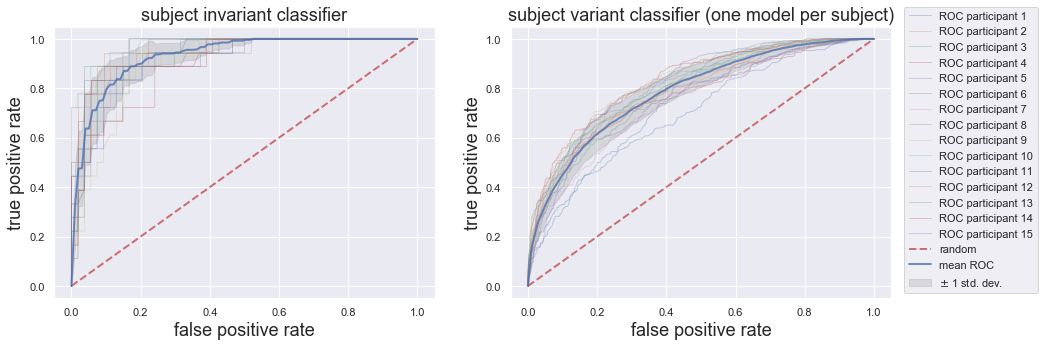

In [36]:
lpgo = LeavePGroupsOut(n_groups=1)
lpgo.get_n_splits(X_flatten, Y_bin, P)

labelsize = 18
titlesize = 18

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = RandomForestClassifier(**best_params)
plt.clf()
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15,5))

metric_data = dict()
for train_index, test_index in lpgo.split(X_flatten_mean, Y_bin, P):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #print('group/participant in Train: {0} and Test: {1}'.format(np.unique(P[train_index]), np.unique(P[test_index])))
    X_train, X_test = X_flatten_mean[train_index], X_flatten_mean[test_index]
    Y_train, Y_test = Y_bin[train_index], Y_bin[test_index]
    #print(f'Y_train unique: {np.unique(Y_train)}')
    
    participant_holdout = int( np.unique(P[test_index])[:])

    #reduce training size 
    X_train, _, Y_train, _ =  train_test_split(X_train,Y_train, test_size=10/20,  
                                                               random_state=0)
    #print(f'X_train/X_test size {X_train.shape[0]}/{X_train.shape[1]} Y_train unique: {np.unique(Y_train)}')
    
    classifier.fit(X_train, Y_train)

    viz = plot_roc_curve(classifier, X_test, Y_test,
                         name='ROC participant {}'.format(participant_holdout),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    
    #plt.title('participant: {0}'.format(participant_holdout))
    #plt.show()
    
    #calculate accuracy
    acc = np.diag(cm).sum() / Y_test.shape[0]
    metric_data[participant_holdout] = dict()
    metric_data[participant_holdout]['acc'] = acc
    
    
#Random Classifier Baseline    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='random', alpha=.8)

#Holdout Classification
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        #label=r'mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        label=r'mean ROC',    
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

handles, labels = ax.get_legend_handles_labels()
new_label = []
for label in labels:
    new_label.append( label.split(' (')[0] )
    

ax.legend(handles, new_label, loc="lower right", bbox_to_anchor = (2, 0, 0.6, 1))

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic")
#ax.legend(loc="lower right", bbox_to_anchor = (2.2, 0, 0.6, 1))
#plt.show()
ax.set_ylabel('true positive rate', size = labelsize)
ax.set_xlabel('false positive rate', size = labelsize)
ax.set_title('subject invariant classifier', size = titlesize)






#train one cassifier per subject

lpgo = LeavePGroupsOut(n_groups=14)
lpgo.get_n_splits(X_flatten, Y_bin, P)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = RandomForestClassifier(**best_params)
#fig, ax = plt.subplots(figsize = (5,5))

metric_data = dict()
for train_index, test_index in lpgo.split(X_flatten_mean, Y_bin, P):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #print('group/participant in Train: {0} and Test: {1}'.format(np.unique(P[train_index]), np.unique(P[test_index])))
    
    #train one classifier per subject
    X_train, X_test, Y_train, Y_test =  train_test_split(X_flatten_mean[train_index],
                                                               Y_bin[train_index], test_size=0.1, 
                                                               random_state=0)
    
    X_train, X_test = X_flatten_mean[train_index], X_flatten_mean[test_index]
    Y_train, Y_test = Y_bin[train_index], Y_bin[test_index]
    #print(f'Y_train unique: {np.unique(Y_train)}')
    print(f'X_train/X_test size {X_train.shape[0]}/{X_train.shape[1]} Y_train unique: {np.unique(Y_train)}')
    
    
    participant_holdout = int( np.unique(P[train_index])[:])
    

    classifier.fit(X_train, Y_train)

    viz = plot_roc_curve(classifier, X_test, Y_test,
                         name='ROC participant {}'.format(participant_holdout),
                         alpha=0.3, lw=1, ax=ax2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    
    #plt.title('participant: {0}'.format(participant_holdout))
    #plt.show()
    
    #calculate accuracy
    acc = np.diag(cm).sum() / Y_test.shape[0]
    metric_data[participant_holdout] = dict()
    metric_data[participant_holdout]['acc'] = acc
    
    
#Random Classifier Baseline    
ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='random', alpha=.8)

#Holdout Classification
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax2.plot(mean_fpr, mean_tpr, color='b',
        label=r'mean ROC' ,
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

#ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#       title="Receiver operating characteristic")
ax2.legend(loc="lower right", bbox_to_anchor = (1.25, 0, 0.6, 1))
#plt.show()
ax2.set_ylabel('true positive rate', size = labelsize)
ax2.set_xlabel('false positive rate', size = labelsize)
ax2.set_title('subject variant classifier (one model per subject)', size = titlesize)

ax2.get_legend().remove()


plt.savefig('plots/subject_dependent_independent_ROC.pdf', dpi = 600, bbox_inches="tight")

## Local Feature importance (Per Observation)

Provide a framework for evaluating the importance of specific features on the predicted outcomes (looking at one eye-tracking subject)

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=col_names, 
                                                   class_names=['default', 'happy'],
                                                   discretize_continuous=True)

In [40]:
#Explaining an instance
#Since this is a multi-class classification problem, we set the top_labels parameter, so that we only explain the top class.
i = np.random.randint(0, X_test.shape[0]) #select one participant
print(f'selected prediction of observation no. {i}')
exp = explainer.explain_instance(X_test[i], classifier.predict_proba, num_features=2, top_labels=1)
#We now explain a single instance:
exp.show_in_notebook(show_table=True, show_all=False)

selected prediction of observation no 387
